We take the pictures without magnification and calculate the radius in pixels. With the knowledge of the real radius of the Moon we then calculate the diameter of a large crater (Copernicus and Plato). These diameters of the craters can then afterwards be used as a reference to convert pixels into meters. 

In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 10, 10
from matplotlib.pyplot import imshow
from numpy.linalg import norm
import rawpy
import PIL
from uncertainties import unumpy as unp
from uncertainties import ufloat
from uncertainties.umath import *
import os

#dummyvalues
r_mond=1737000. #r_mond in meter
pixerr=30

In [17]:
import import_ipynb
from astro_functions import radius_finder, infos_crater_unc_ver2, coordinates, betafinder

Class which makes it possible to have an interactive picture with matplotlib.

In [18]:
class LineBuilder:
    def __init__(self, line,number):
        self.line = line
        self.xs = list(line.get_xdata())
        self.ys = list(line.get_ydata())
        self.cid = line.figure.canvas.mpl_connect('button_press_event', self)
        self.anzahl=number
    def __call__(self, event):
        if event.inaxes!=self.line.axes: return
        self.xs.append(event.xdata)
        self.ys.append(event.ydata)
        self.line.set_data(self.xs, self.ys)
        self.line.figure.canvas.draw()
        if len(self.xs)==self.anzahl:
            line.figure.canvas.mpl_disconnect(self.cid)

Moon phase angle (phi from proposal) with http://www.mondkalender-online.de/mondkalender/wunschkinder/mondwinkel-rechner.php.
Time of nomag: 16.01.2019 01:15 -> websiteangle = 110°

In [19]:
degtorad=np.pi/180.
websiteangle=110.
phi=(180.-websiteangle)*degtorad

In the following the RAW files are imported and analysed. 
One has to choose 3 points on the edges of the Moon to determine the radius of the Moon in pixel. 
First a folder called "Moon_radius" is imported and the number of elements in this folder is printed. The second and the third box will be executed for all elements in the folder. To do so you have to change the Variable i in the second box to change the image you are working with (i goes from 0 to the number of elements in the folder). Then you can start to select the 3 point in the picture. After that the third box will append the radius to the list "all_radi".  

In [22]:
# only once 
files = os.listdir('Moon_radius')
all_radi = []
all_mitt = []
print(files)
print(len(files))

['IMG_1939.CR2', 'IMG_1940.CR2']
2


<IPython.core.display.Javascript object>


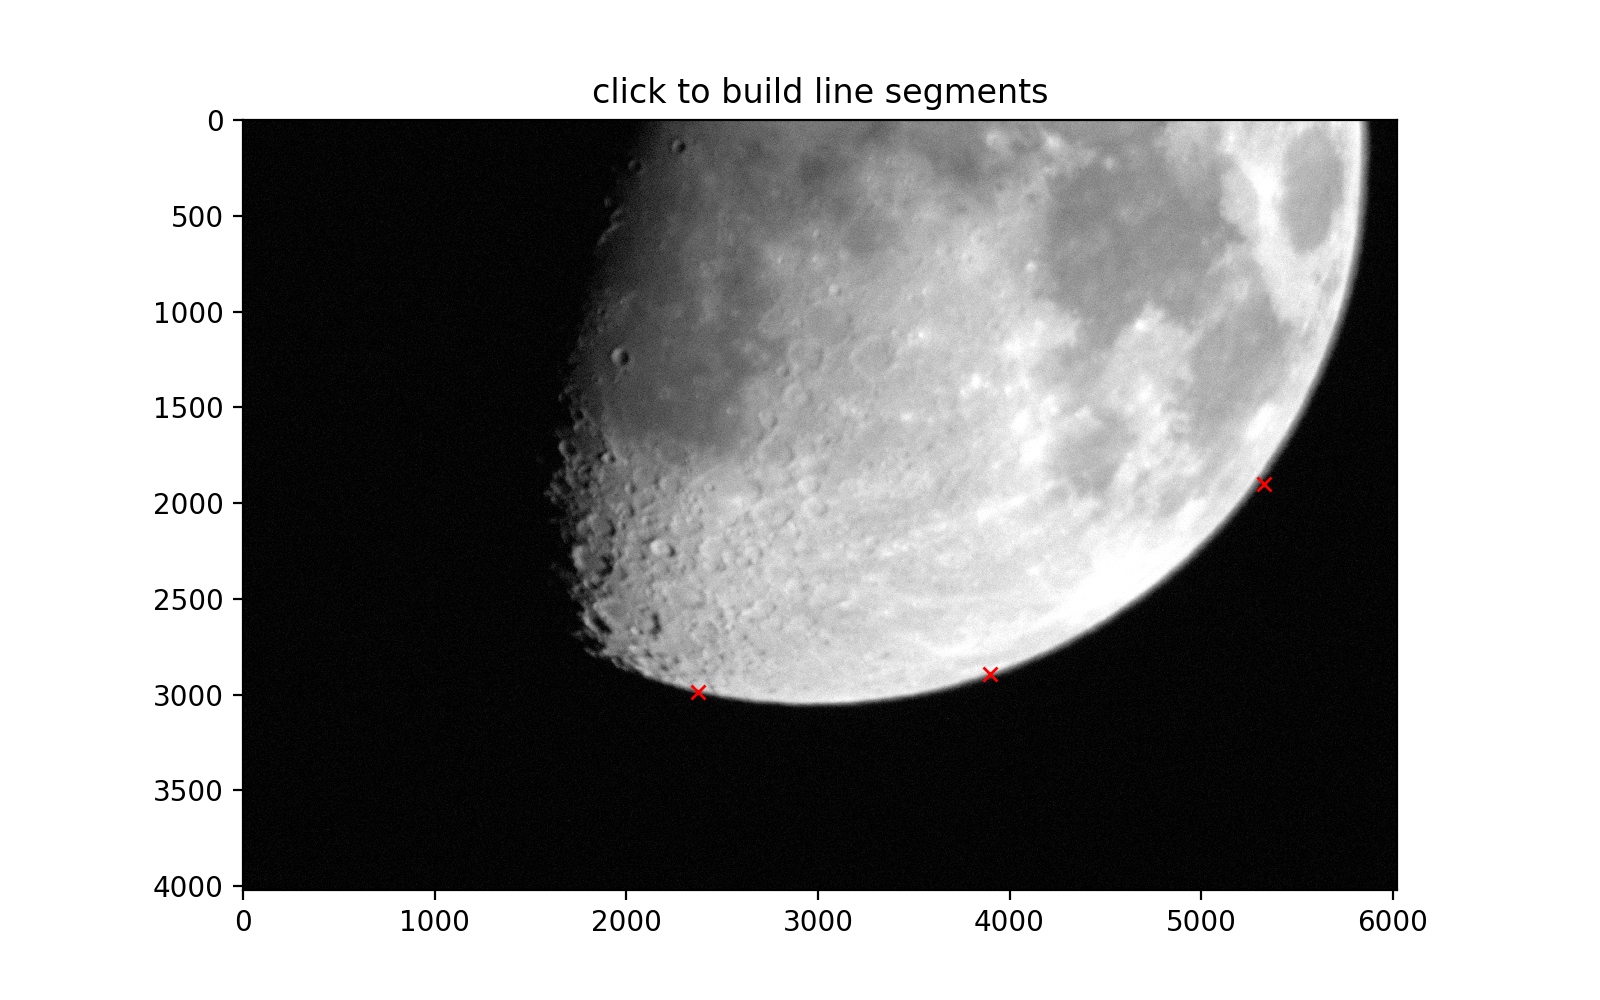

You can start selecting


In [26]:
n = 3
i = 0 #Has to be change from 0 to len(file), to get the radius of the Moon in each picture
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.set_title('click to build line segments')
line, = ax.plot([], [], color='r', marker='x', markersize=5, linestyle='')  # empty line
linebuilder = LineBuilder(line, n)
raw = rawpy.imread('Moon_radius/'+files[i])

rgb = raw.postprocess(use_camera_wb=True)
intensity = np.sum(rgb, axis=2)/3.0
picture = rgb
for i in range(3):
    picture[:,:,i] = intensity
#picture = plt.imread('MondMerge.jpg')
imshow(picture)
#PIL.Image.fromarray(rgb).save('image.jpg', qualityYou can start selecting=90, optimize=True)
raw.close()
print('You can start selecting')
plt.show()

In [27]:
xwerte=linebuilder.xs
ywerte=linebuilder.ys
radisu, mitt=radius_finder(xwerte,ywerte)
all_radi.append(radisu)
all_mitt.append(mitt)
print("previous Radii:")
print(all_radi)
print("previous centers of the circle")
print(all_mitt)

previous Radii:
[1990.6100396128204+/-66.8984018109091]
previous centers of the circle
[array([3097.1865742693835+/-28.5620010239263,
       1278.4982933312017+/-84.58869328172017], dtype=object)]


Now we can calculate the mean pixel radius.

In [28]:
all_radi = np.array(all_radi)
radi_pix = np.mean(all_radi)
print("Mean radius: ", radi_pix)
all_mitt = np.array(all_mitt)
mitt_pix = np.mean(all_mitt, axis=0)
print("Mean center of the circle: ", mitt_pix)

Mean radius:  (1.99+/-0.07)e+03
Mean center of the circle:  [3097.1865742693835+/-28.5620010239263
 1278.4982933312017+/-84.58869328172018]


We now want to find the diameter of the crater.
We look at the pictures in Moon_pictures and mark the crater with 2 points. 
1. Start crater
2. End crater
Additionally we mark two points to find the depth of the crater.
3. Start of the shadow
4. End of the shadow

In [30]:
craters = os.listdir('Moon_radius')
print(len(craters))


coord = []
depths = []
diameters = []

2


<IPython.core.display.Javascript object>


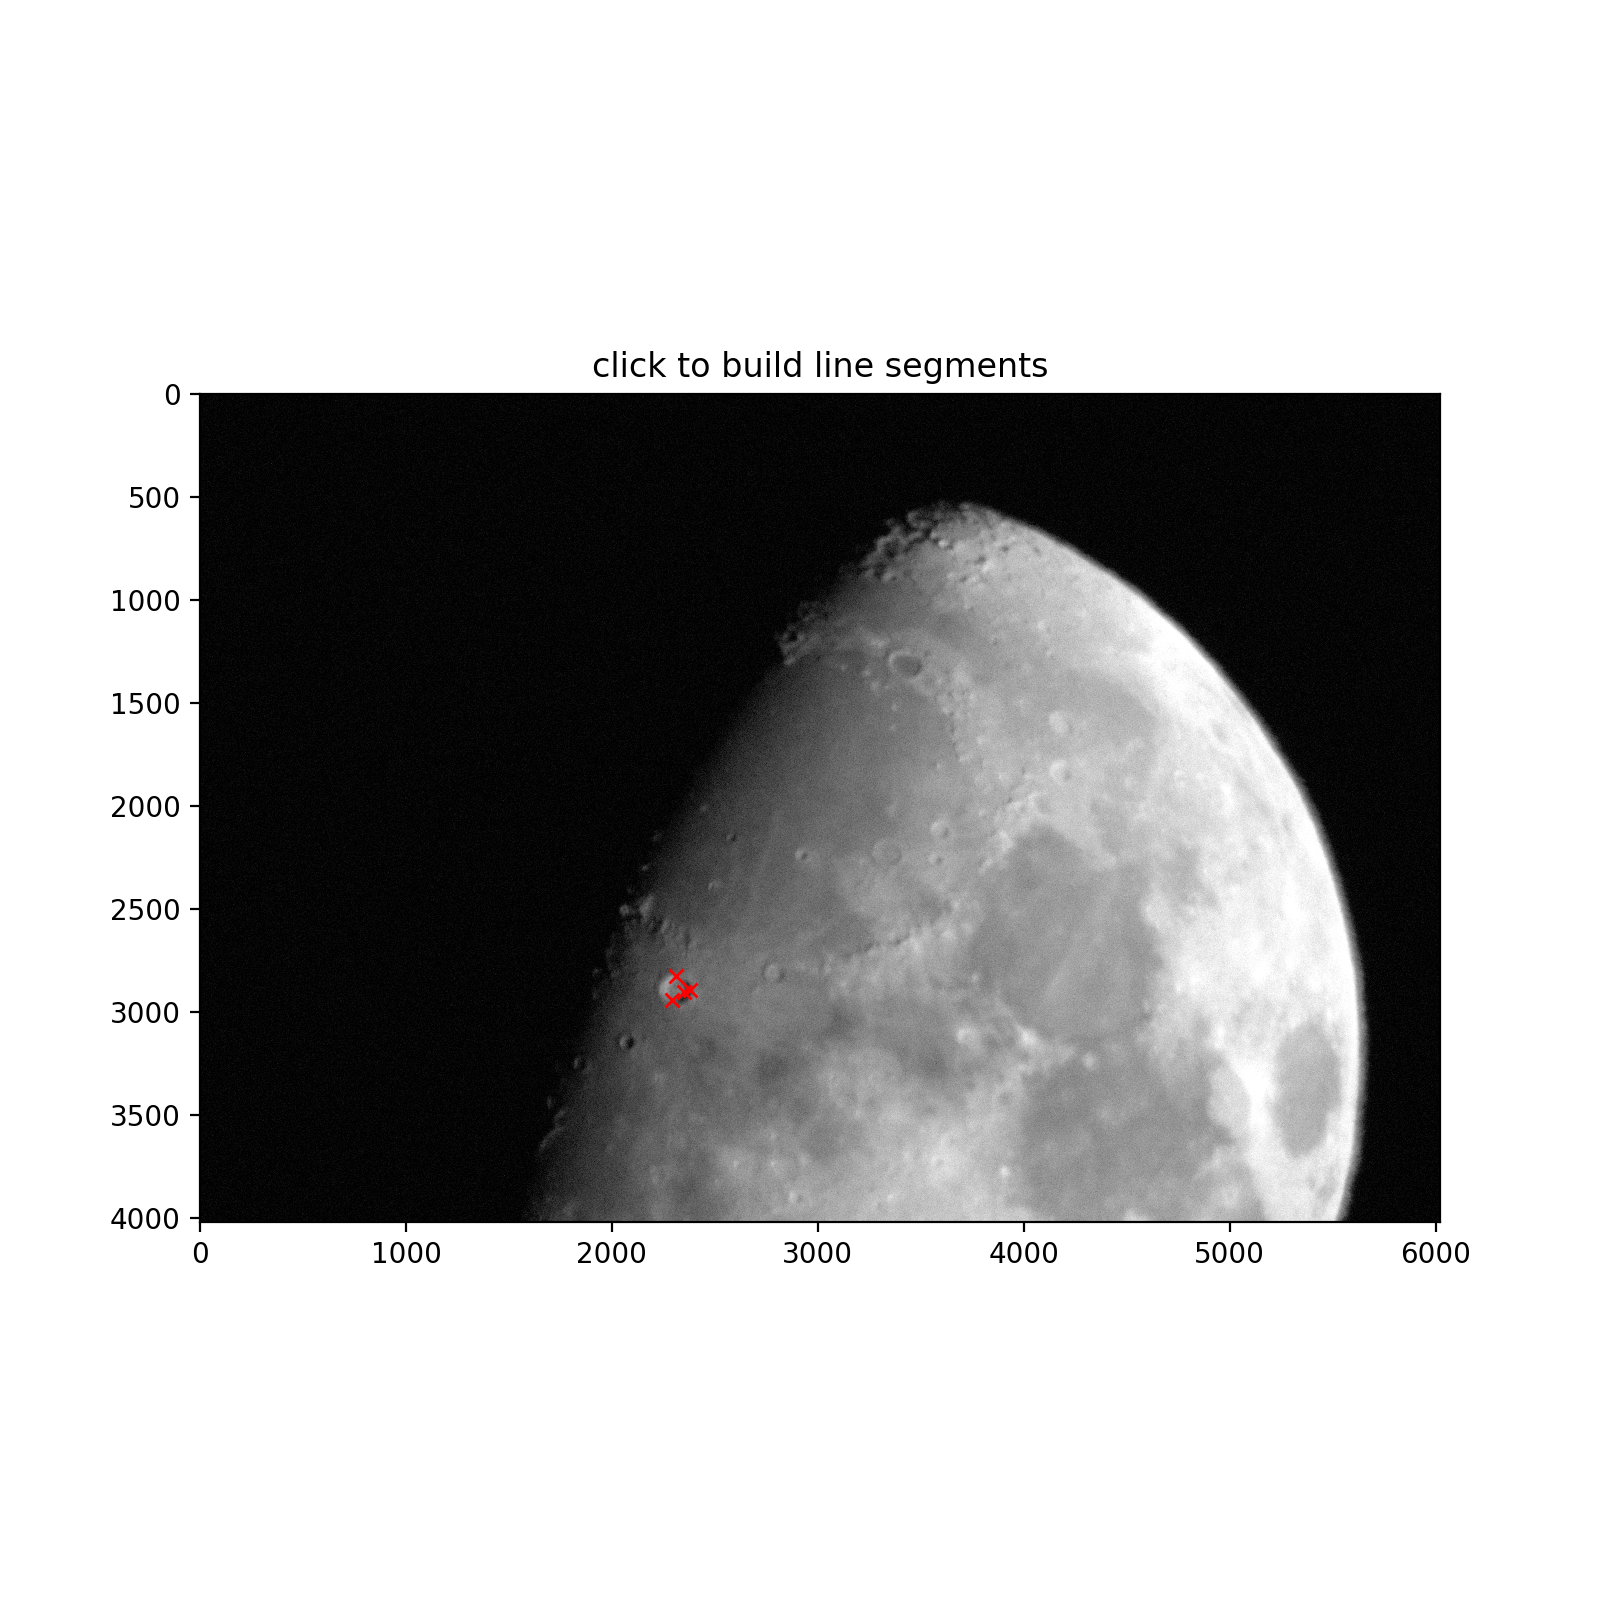

You can start selecting


In [32]:
n=4
i = 1 #The variable which indicates the picture

#fig = plt.figure(figsize=(8,5))
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_title('click to build line segments')
line, = ax.plot([], [], color='r', marker='x', markersize=5, linestyle='')  # empty line
linebuilder = LineBuilder(line, n)
raw = rawpy.imread('Moon_radius/'+craters[i])
rgb = raw.postprocess(use_camera_wb=True)
intensity = np.sum(rgb, axis=2)/3.0
picture = rgb
for j in range(3):
    picture[:,:,j] = intensity
    
#picture = plt.imread('MondMerge.jpg')
imshow(picture)
raw.close()
print('You can start selecting')
plt.show()
    

In [33]:
xvalues=linebuilder.xs
yvalues=linebuilder.ys

Now we select our crater on the image of the whole crater to find its coordinates in our coordinate system.

<IPython.core.display.Javascript object>


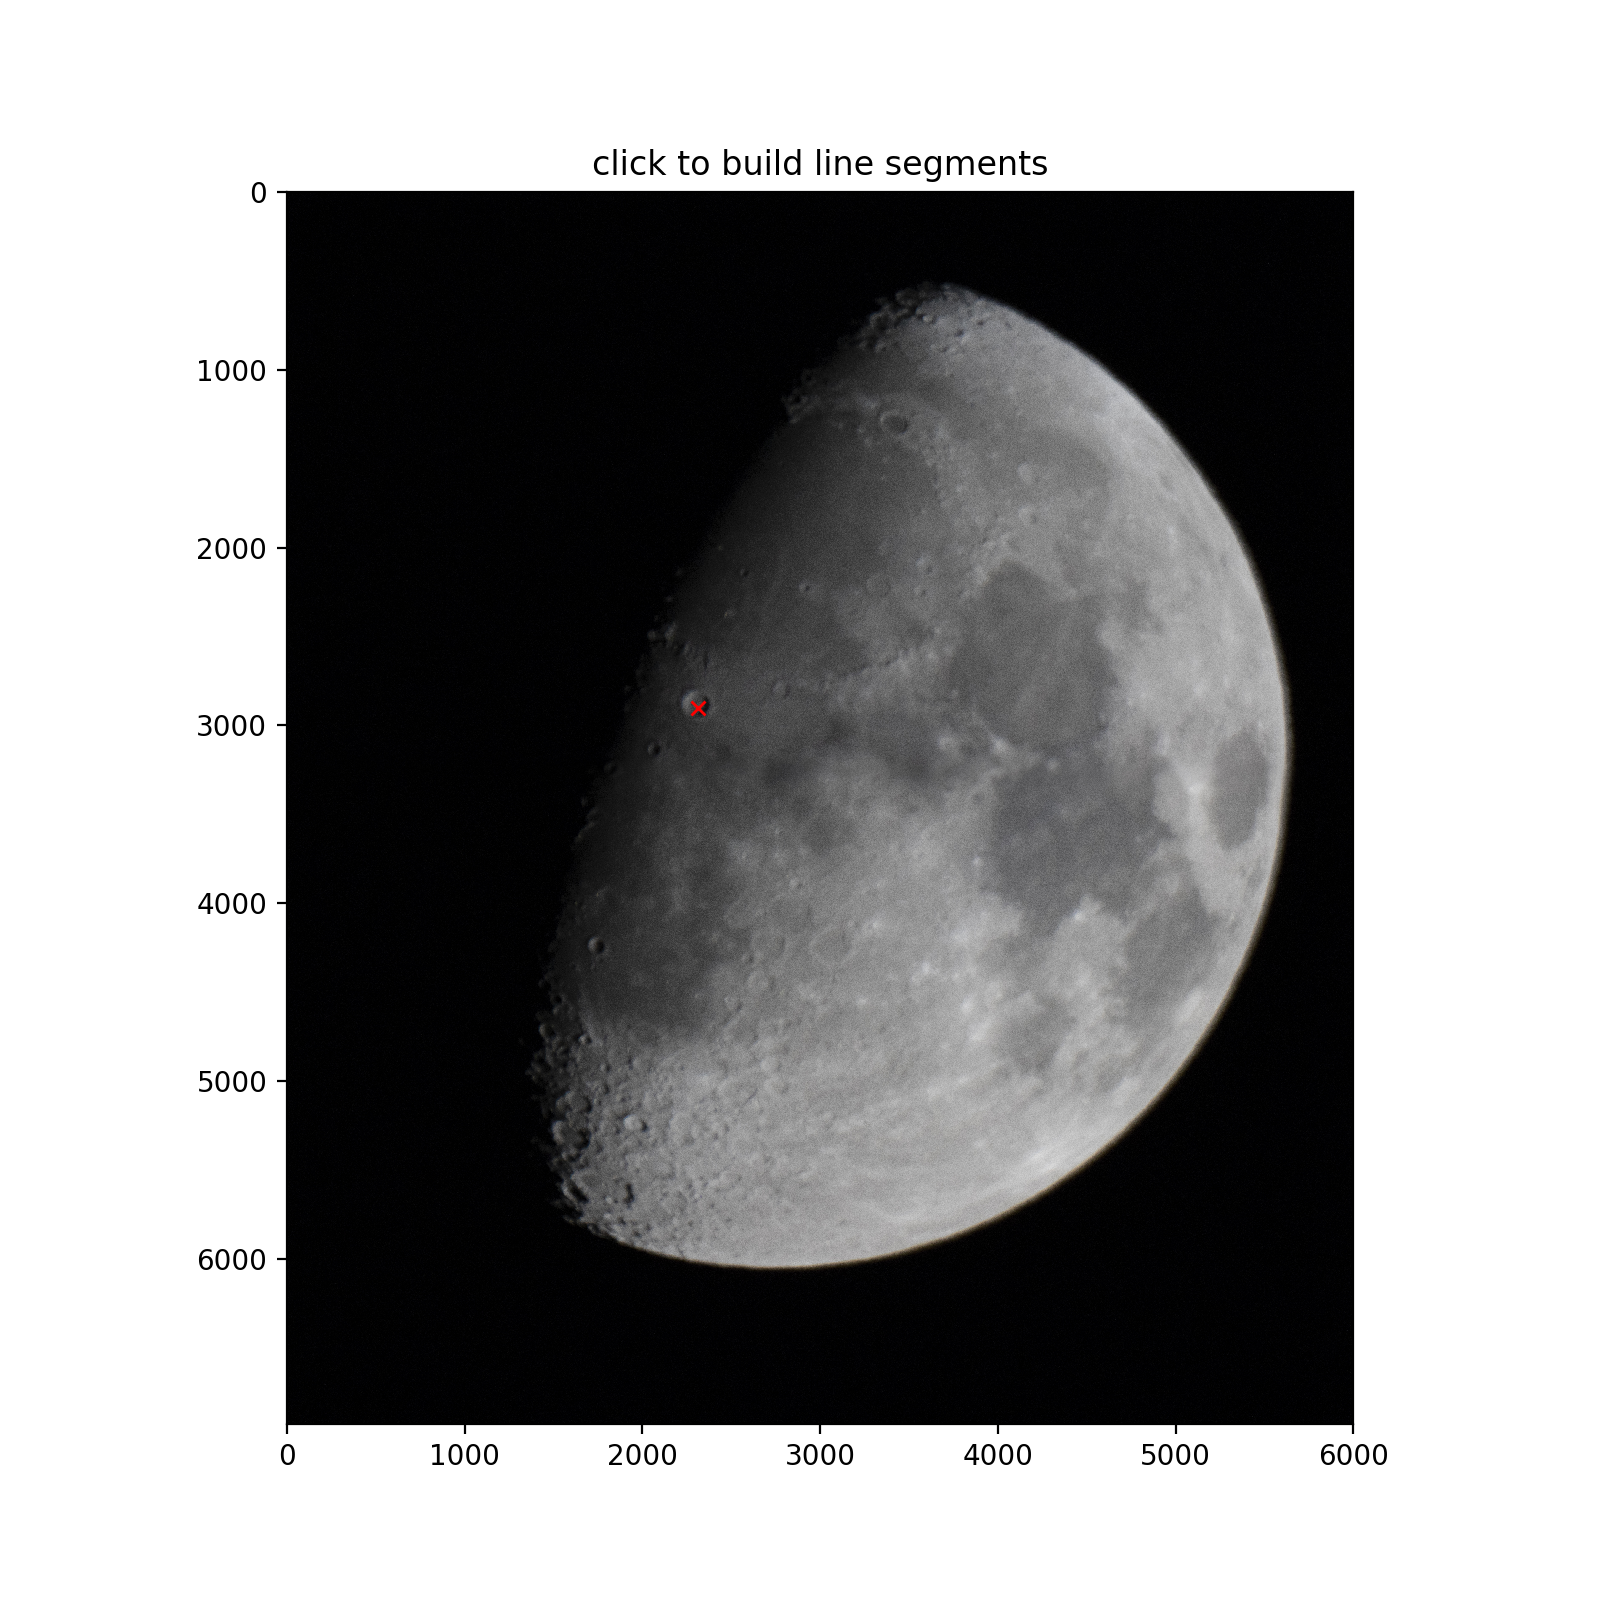

You can start selecting


In [35]:
n=1
#fig = plt.figure()#default
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_title('click to build line segments')
line, = ax.plot([], [], color='r', marker='x', markersize=5, linestyle='')  # empty line
linebuilder = LineBuilder(line, n)
jpg = plt.imread('MondMerge.jpg')

imshow(jpg)
#PIL.Image.fromarray(rgb).save('image.jpg', quality=90, optimize=True)
#print(np.mean(intensity))
print('You can start selecting')
plt.show()

Calculate the coordinates.

In [36]:
xpunkt=linebuilder.xs
ypunkt=linebuilder.ys
coo = coordinates(xpunkt[0],ypunkt[0])
coord.append(coo)
print('The coordinates of this point are:')   
print(coo)

The coordinates of this point are:
(-371.4213856288855+/-36.748789419204854, 91.97794481717115+/-36.84727420040977)


We take the coordinates of the crater (coo) and the values to the crater (xvalues, yvalues) and the found pixel radius. With these values we now calculate the depth and the diameter fo teh crater.

In [37]:
beta, H_mess = betafinder(coo)
print("Beta = ", beta/np.pi*180)
print("H_mess = ", H_mess)
diameter, depth = infos_crater_unc_ver2(xvalues, yvalues, beta, phi, H_mess, radi_pix)
print("Diameter of the crater = ", diameter)
print("Depth of the crater = ", depth)
depths.append(depth)
diameters.append(diameter)

Beta =  8.0+/-0.7
H_mess =  (5.4+/-2.2)e+04
Diameter of the crater =  (1.0+/-0.4)e+05
Depth of the crater =  (4+/-5)e+03


We save the coordinates of the crater as well as its diameter and its depth each in a text file. 

In [38]:
Co = open('Coordinates', 'w')
Co.write(str(coord))
Co.close()
Dia = open('Diameters', 'w')
Dia.write(str(diameters))
Dia.close()
De = open('Depths', 'w')
De.write(str(depths))
De.close()